### Computational Guided Inquiry for Modeling Earth's Climate (Neshyba & Posta, 2025)

# Cambio 1.0

### Overview
Here we'll put together a climate model based on carbon mass balance involving the atmosphere, land, and the oceans.

$$
F_{land->atm} =  k_{la} \ \ \ (1) 
$$

$$
F_{atm->land} = k_{al0} +  k_{al1} \times [C_{atm}] \ \ \ (2)
$$

$$
F_{ocean->atm} = k_{oa} [C_{ocean}] \ \ \ (3)
$$

$$
F_{atm->ocean} = k_{ao} [C_{atm}] \ \ \ (4)
$$

$$
F_{human->atm} = \epsilon(t) \ \ \ (5)
$$

### Euler's method
As previously, we'll solve this problem numerically by setting up a loop. We'll be tracking the concentration of carbon in the *ocean* reservoir, as well as the atmospheric reservoir:

$$
[C_{atm}]_{n+1} = [C_{atm}]_{n}+(F_{land->atm}+F_{ocean->atm}+F_{human->atm}-F_{atm->land}-F_{atm->ocean}) \times \Delta t \ \ \ (6)
$$

$$
[C_{ocean}]_{n+1} = [C_{ocean}]_{n}+(F_{atm->ocean}-F_{ocean->atm}) \times \Delta t \ \ \ (7)
$$

where $[C_{atm}]_{n+1}$ means "amount of carbon in the atmosphere in the next step" and $[C_{atm}]_{n}$ means "amount of carbon in the atmosphere in the last step," and so on. In Python, we'll be implementing Eqs. 6 and 7 using the "+=" construct, which we encountered before in CumulativeAnalysis. You'll also need to upload your emission scenario file into the Cambio1.0 folder.

### Learning goals
1. I can set up and numerically solve coupled ordinary differential equations describing the carbon mass balance between the atmosphere, land, and oceans.
1. I can describe what the "+=" construct does in Python.
1. I have a sense of the % of annual anthropogenic emissions that are absorbed by the oceans and the land at present, and of when the ocean will stop being a sink and start to become a net source of $CO_2$ to the atmosphere. 
1. I have a sense of the delay between the *timing of peak anthropogenic emissions* and *the timing of maximum atmospheric $CO_2$*, and of the reason behind that delay.
1. I can translate between carbon amounts in the atmosphere from GtC to ppm, and back.

In [2]:
import numpy as np
import matplotlib.pyplot as plt; plt.rc("figure", figsize=(12,8))
import meclib.cl as cl

### Load your scenario
To get the file you generated in *ScheduledFlows* into your current work space, _download_ it to your laptop or desktop, then _upload_ it to the current folder. 

Once you've done that, in the cell below, first you should assign a filename to your *ScheduledFlows* file, something like this (but using your filename, of course):

    filename = 'Peaks_in_2040.pkl'

Then, use cl.LoadMyScenario to load the scenario into Python as a dictionary named epsdictionary_fromfile. Something like this should work:

    time, eps, epsdictionary_fromfile = cl.LoadMyScenario(filename, verbose=True)

{'dataframe':             time  emissions
0    1750.000000   0.134987
1    1750.667780   0.136492
2    1751.335559   0.138013
3    1752.003339   0.139552
4    1752.671119   0.141107
..           ...        ...
595  2147.328881   4.000000
596  2147.996661   4.000000
597  2148.664441   4.000000
598  2149.332220   4.000000
599  2150.000000   4.000000

[600 rows x 2 columns], 't_0': 2003, 'eps_0': 9, 't_peak': 2040, 't_decarb': 15, 'k': 0.0166}


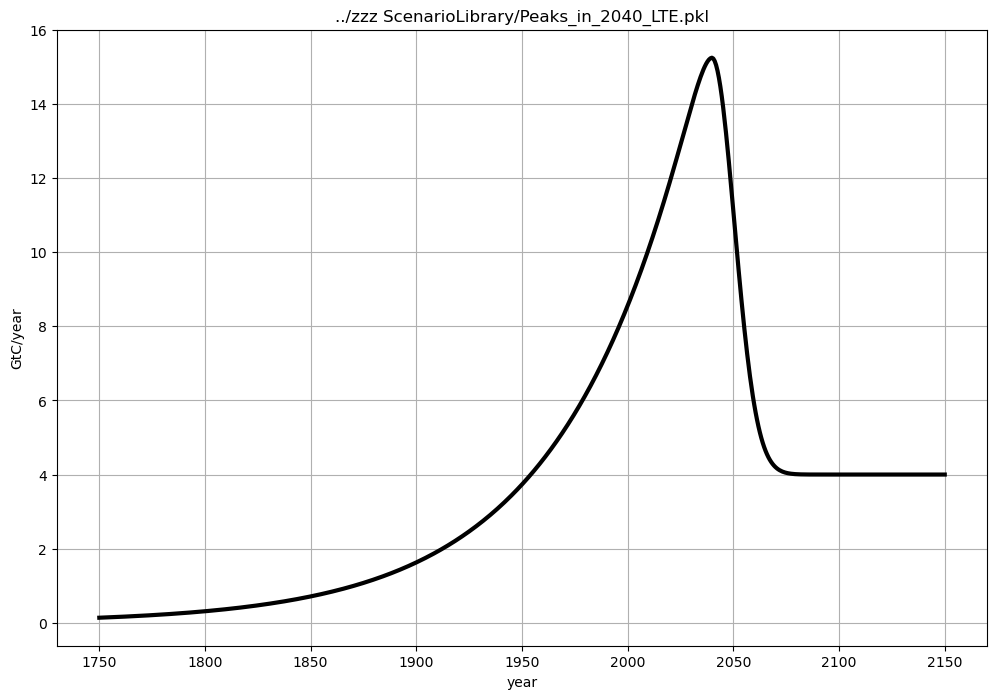

In [4]:
## BEGIN SOLUTION

# Name of the file
# filename = '../zzz ScenarioLibrary/Peaks_in_2040_default.pkl'
filename = '../zzz ScenarioLibrary/Peaks_in_2040_LTE.pkl'
# filename = 'MyScenario_Peak2035_bkeri.pkl'
# filename = 'Peaks_in_2040.pkl'
time, eps, epsdictionary_fromfile = cl.LoadMyScenario(filename,verbose=True)

### END SOLUTION

### Rate constants and initial conditions
In the cell below, we'll get started with the time step, which you can get from the difference between the first two elements of your $t$ array. 

You'll also need to specify the 1st order rate constants, as follows:

    k_la = 120
    k_al0 = 110.684
    k_al1 = 0.0157895
    k_oa = 0.169405
    k_ao = 0.117949

In [6]:
### BEGIN SOLUTION

# # Specify rate constants (as returned by cl.CreateClimateParams)
# k_la = 120
# k_al0 = 110.6842105263158
# k_al1 = 0.015789473684210527
# k_oa = 0.1694051282051282
# k_ao = 0.11794871794871795

# Specify rate constants (approximations of values returned by cl.CreateClimateParams; this avoids a divide by zero)
k_la = 120
k_al0 = 110.684
k_al1 = 0.0157895
k_oa = 0.169405
k_ao = 0.117949

# Shortened numbers that appear in the assignment
k_la = 120
k_al0 = 110.7
k_al1 = 0.01579
k_oa = 0.1694
k_ao = 0.1179


# Calculate the time step
dt = time[1]-time[0]

### END SOLUTION

### Solving the model using Euler's method
Your challenge is to solve the model laid out in Eqs. (1-5) using Euler's method, using the algorithms laid out in Eqs. (6-7). We've specified the starting concentrations of carbon in the atmosphere, as the pre-industrial amounts (see below). After that, the loop you set up should look a lot like what you did in CumulativeEmissions (e.g., the time frame should be the times embedded in your anthropogenic emissions model).

After you have done that, you should provide some graphical output, as follows.

1. A flux timeline, in which timelines of the anthopogenic flux ($\epsilon(t)$), the net land-to-atmosphere flux ($F_{land->atm}-F_{atm->land}$), and the net ocean-to-atmosphere flux ($F_{ocean->atm}-F_{atm->ocean}$) all appear on a single graph;
1. A concentration timeline, in which the concentrations (in GtC) of carbon in the atmosphere and oceans appear on a single graph;
1. Another concentration timeline, this one only of the concentration of carbon in the atmosphere, but converted to ppm (i.e., your array of C_atm divided by 2.12).

Annotate all these graphs using the label/legend method. 

Text(0.5, 1.0, 'Net fluxes and anthropogenic (GtC/year)')

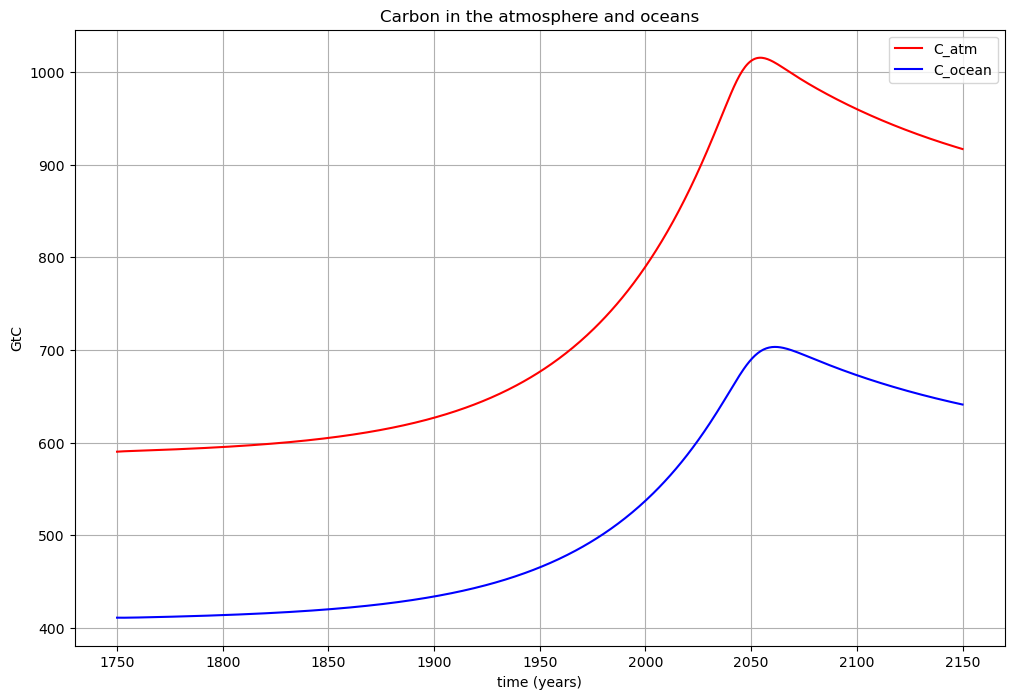

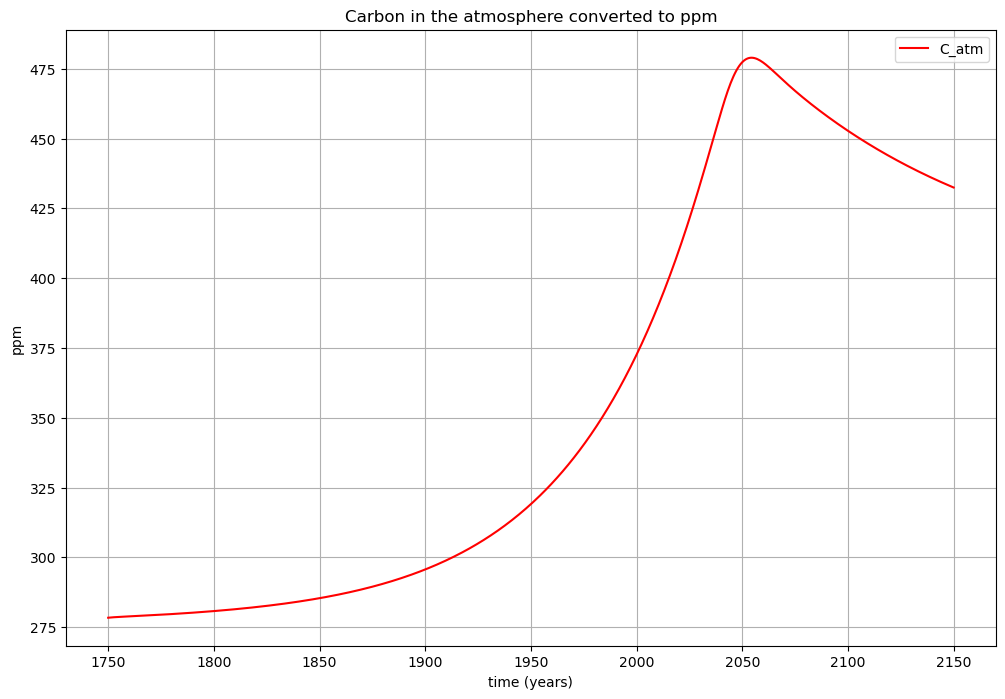

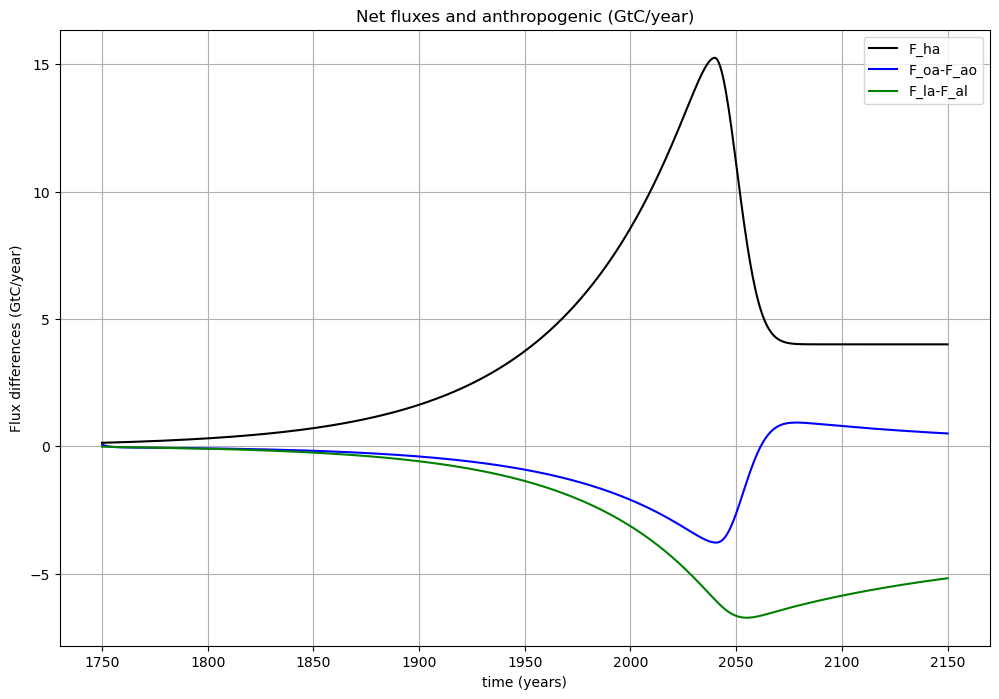

In [8]:
# This specifies beginning reservoir amounts in the atmosphere (C_atm) and oceans (C_ocean), in GtC. 
C_atm = 590
C_ocean = 411

# Initialize empty numpy arrays that will hold the atmospheric & oceanic carbon amounts 
C_atm_array = np.empty(0)
C_ocean_array = np.empty(0)

# Also initialize empty numpy arrays that will hold the fluxes (you can call them F_la_array, etc)
### BEGIN SOLUTION

F_la_array = np.empty(0)
F_al_array = np.empty(0)
F_ao_array = np.empty(0)
F_oa_array = np.empty(0)

### END SOLUTION

# Use an Euler's loop over time to calculate reservoir amounts and fluxes, then plot results as described above
### BEGIN SOLUTION

for i in range(len(time)):
    
    # This calculates the fluxes of this iteration of the loop
    F_al = k_al0 + k_al1*C_atm
    F_la = k_la
    
    F_oa = k_oa*C_ocean    
    F_ao = k_ao*C_atm
    
    # Get the new C_atm and C_ocean
    C_atm += (F_la + F_oa - F_ao - F_al + eps[i])*dt
    C_ocean += (F_ao - F_oa)*dt
    
    # Append to arrays
    C_atm_array = np.append(C_atm_array,C_atm)
    C_ocean_array = np.append(C_ocean_array,C_ocean)
    F_la_array = np.append(F_la_array,F_la)
    F_al_array = np.append(F_al_array,F_al)
    F_oa_array = np.append(F_oa_array,F_oa)
    F_ao_array = np.append(F_ao_array,F_ao)
        

# Plotting the concentrations (C_atm and C_ocean) on one graph, in GtC
plt.figure()
plt.plot(time,C_atm_array,'red',label='C_atm')
plt.plot(time,C_ocean_array,'b',label='C_ocean')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("GtC")
plt.title('Carbon in the atmosphere and oceans')
plt.legend()

# Plot the atmospheric concentration in ppm (by dividing C_atm by 2.12)
plt.figure()
plt.plot(time,C_atm_array/2.12,'red',label='C_atm')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("ppm")
plt.legend()
plt.title('Carbon in the atmosphere converted to ppm')

# Not part of the solution, just checking for consistency
ClimateParams = cl.CreateClimateParams(epsdictionary_fromfile)
(ClimateParams)
T_anomaly_array = cl.Diagnose_T_anomaly(C_atm_array, 0.3, ClimateParams)
Tmax = np.max(T_anomaly_array)
('Calculated maximum temperature:', Tmax)

# Plot the net fluxes
plt.figure()
F_land_net = F_la_array-F_al_array
F_ocean_net = F_oa_array-F_ao_array
plt.plot(time,eps,label='F_ha',color='k')
plt.plot(time,F_ocean_net,label='F_oa-F_ao',color='b')
plt.plot(time,F_land_net,label='F_la-F_al',color='g')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("Flux differences (GtC/year)")
plt.legend()
plt.title('Net fluxes and anthropogenic (GtC/year)')

### END SOLUTION

### A little more graphical analysis
In the cell below, calculate the *excess* carbon in the atmosphere, i.e., 
$[C_{atm,excess}] = [C_{atm}]-[C_{atm}]^{preindustrial}$, where $[C_{atm}]^{preindustrial}$ is the starting concentration of $CO_2$ (i.e., C_atm_array[0]). Do the same for the ocean atmospheric carbon, $[C_{ocean,excess}] = [C_{ocean}]-[C_{ocean}]^{preindustrial}$.

Then, plot $[C_{atm,excess}]$ and $[C_{ocean,excess}]$ on the same graph, as a function of time -- but instead of using Python's *plt.plot* command, use *plt.semilogy* (which puts the vertical axis on a log scale). Annotate using the label/legend method.

k_growthphase = 0.016955236391397708
k_recoveryphase = -0.002477575916458809
tau_recoveryphase = 403.6203263669501
analytical k_recoveryphase = -0.009310219282979463
analytical tau_recoveryphase = 107.40885575360791
k_growthphase = 0.016955236391397708
k_recoveryphase = -0.002477575916458809
analytical k_recoveryphase = -0.009310219282979463
analytical tau_recoveryphase = 107.40885575360791
sequestration ratio limit (green) = 0.6663874645038715


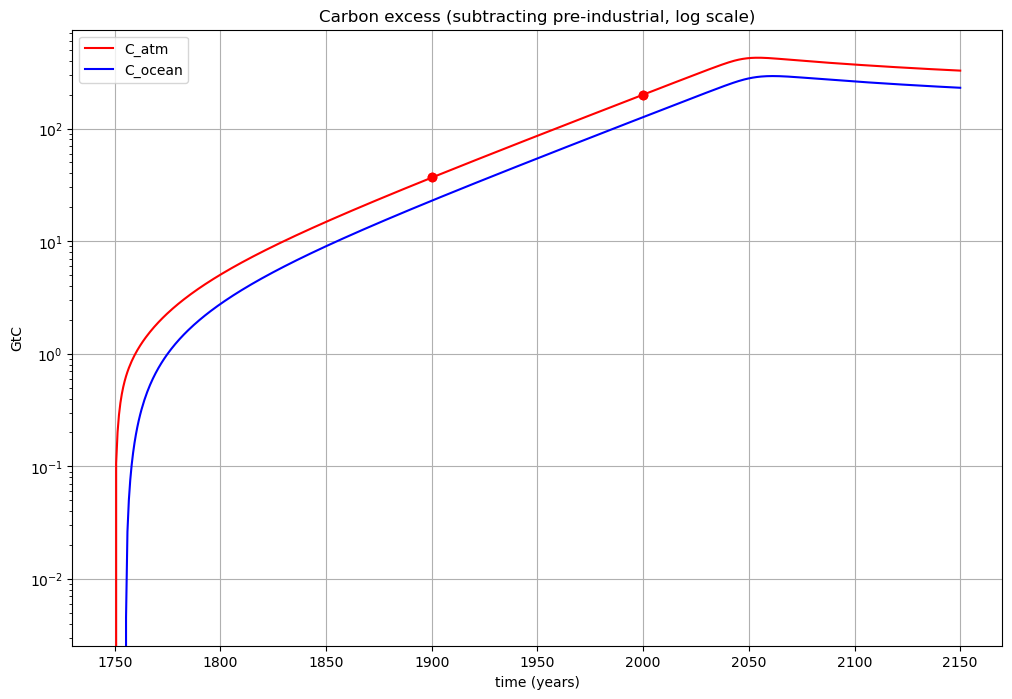

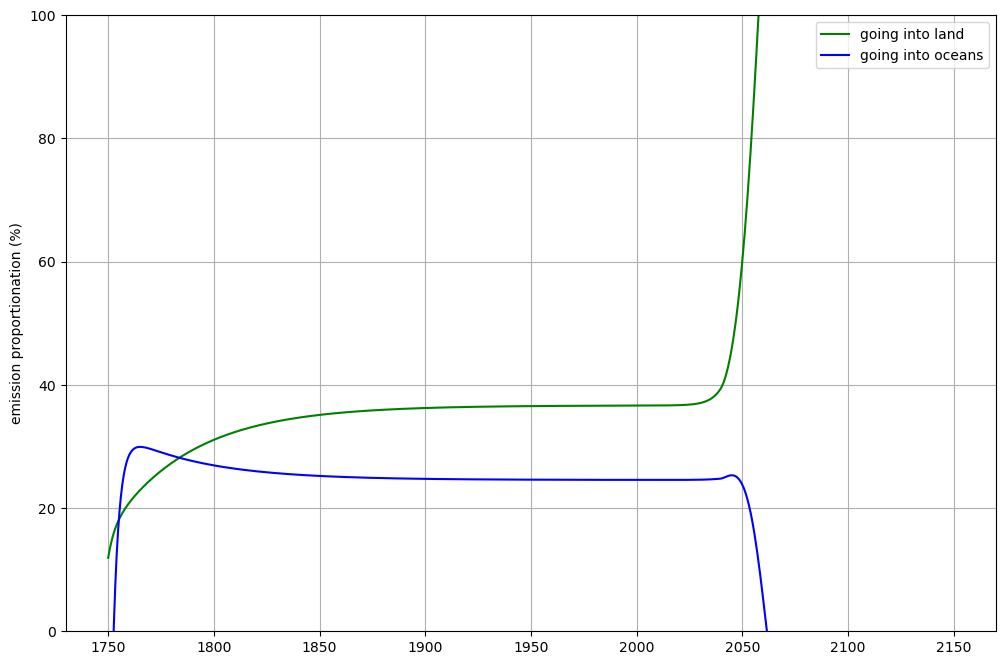

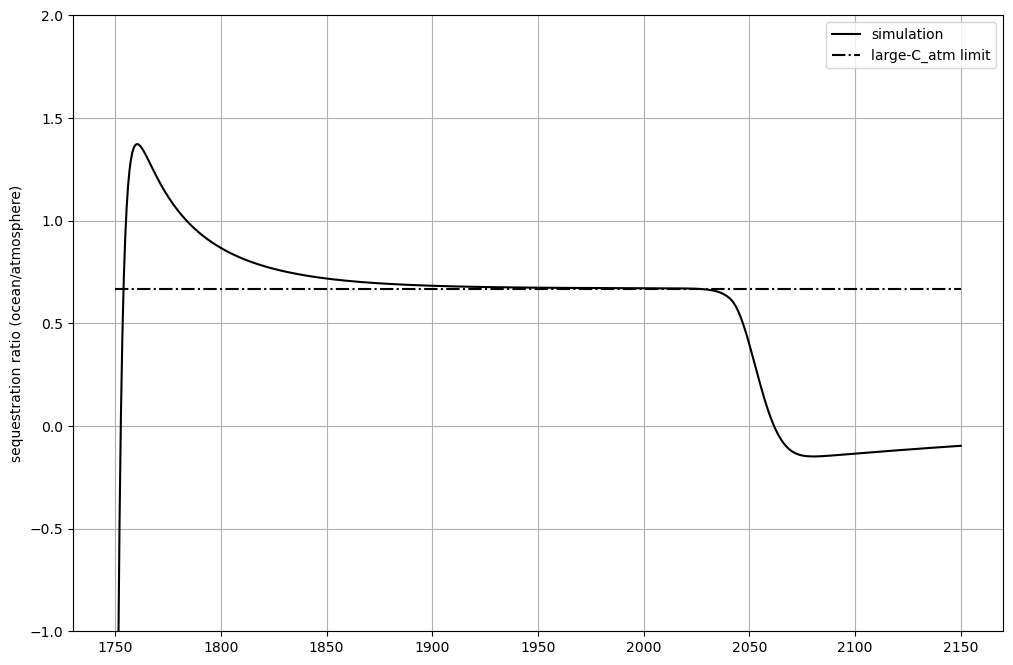

In [10]:
### BEGIN SOLUTION

plt.figure()
C_atm_excess = C_atm_array-C_atm_array[0]
C_ocean_excess = C_ocean_array-C_ocean_array[0]
plt.semilogy(time,C_atm_excess,'r',label='C_atm')
plt.semilogy(time,C_ocean_excess,'b',label='C_ocean')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("GtC")
plt.title('Carbon excess (subtracting pre-industrial, log scale)')
plt.legend()

# Code below is not part of the solution

# Getting the slope in the various phases
def find_inearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
time1 = 1900
time2 = 2000
itime1 = find_inearest(time, time1)
itime2 = find_inearest(time, time2)
plt.semilogy([time[itime1],time[itime2]],[C_atm_excess[itime1],C_atm_excess[itime2]],'ro')
k_growthphase = np.log(C_atm_excess[itime2]/C_atm_excess[itime1])/(time[itime2]-time[itime1])
print('k_growthphase =',k_growthphase)
time1 = 2100
time2 = 2150
itime1 = find_inearest(time, time1)
itime2 = find_inearest(time, time2)
# plt.semilogy([time[itime1],time[itime2]],[C_atm_excess[itime1],C_atm_excess[itime2]],'bo')
k_recoveryphase = np.log(C_atm_excess[itime2]/C_atm_excess[itime1])/(time[itime2]-time[itime1])
print('k_recoveryphase =',k_recoveryphase)
print('tau_recoveryphase =',-1/k_recoveryphase)
k_recoveryphase_analytical = -k_al1/(1+k_ao/k_oa)
print('analytical k_recoveryphase =', k_recoveryphase_analytical)
print('analytical tau_recoveryphase =',-1/k_recoveryphase_analytical)

# Getting the slope in the various phases
def find_inearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
time1 = 1900
time2 = 2000
itime1 = find_inearest(time, time1)
itime2 = find_inearest(time, time2)
plt.semilogy([time[itime1],time[itime2]],[C_atm_excess[itime1],C_atm_excess[itime2]],'ro')
k_growthphase = np.log(C_atm_excess[itime2]/C_atm_excess[itime1])/(time[itime2]-time[itime1])
print('k_growthphase =',k_growthphase)
time1 = 2100
time2 = 2150
itime1 = find_inearest(time, time1)
itime2 = find_inearest(time, time2)
# plt.semilogy([time[itime1],time[itime2]],[C_atm_excess[itime1],C_atm_excess[itime2]],'ro')
k_recoveryphase = np.log(C_atm_excess[itime2]/C_atm_excess[itime1])/(time[itime2]-time[itime1])
print('k_recoveryphase =',k_recoveryphase)
('tau_recoveryphase =',-1/k_recoveryphase)
k_recoveryphase_analytical = -k_al1/(1+k_ao/k_oa)
print('analytical k_recoveryphase =', k_recoveryphase_analytical)
print('analytical tau_recoveryphase =',-1/k_recoveryphase_analytical)
plt.legend()

# Exploring the proportionation
plt.figure()
plt.plot(time,-F_land_net/eps*100,'g',label='going into land')
plt.plot(time,-F_ocean_net/eps*100,'b',label='going into oceans')
plt.ylabel('emission proportionation (%)')
plt.ylim([0,100])
plt.grid(True)
plt.legend()

# Exploring the sequestration ratio
sequestration_ratio = F_ocean_net/F_land_net
plt.figure()
plt.plot(time,sequestration_ratio,'k',label='simulation')
plt.ylabel('sequestration ratio (ocean/atmosphere)')
plt.grid(True)

# Getting the limiting case
C_atm_big = 1000*C_atm_array[0]
F_al_big = k_al0 + k_al1*C_atm_big
F_ao_big = k_ao*C_atm_big
F_la_big = k_la
F_land_net_big = F_la_big-F_al_big
k = epsdictionary_fromfile['k']; ('k =', k)
sequestration_ratio_big = k*(1/(k+k_oa)*(k_ao))/k_al1
print('sequestration ratio limit (green) =', sequestration_ratio_big)
plt.plot([time[0],time[-1]],[sequestration_ratio_big,sequestration_ratio_big],'k-.',label='large-C_atm limit')
plt.ylim([-1,2])
plt.legend()

# # Seeing what k_oa needs to be to satisfy an observed sequestration ratio
# sequestration_ratio_obs = 2/3
# k_oa_test = k*(k_ao/(sequestration_ratio_obs*k_al1)-1)
# ('Method 2 result for k_oa = ', k_oa_test)



### END SOLUTION


### Pause for analyis
In the cell below, do some analysis of your results:

1. You may have noticed that the timing of maximum atmospheric $CO_2$ concentration is delayed a few years after the timing of maximum anthropogenic *emissions*. How many years is this delay? 
1. What is concentration of $CO_2$, in ppm, at its maximum? 
1. It's subtle, but if you look at the timelines of carbon in the atmosphere and ocean, you'll see that one peaks a few years after the other. Which peaks first, and why do you suppose there is a delay?
1. Based on your "Net fluxes" graph, estimate the % of anthropogenic emissions in the year 2023 that will be absorbed by land, and the % that will be absorbed by oceans. You'll need to use the "zoom" feature to get these numbers accurately.
1. In approximately what year will the ocean will start to become a net source of $CO_2$ to the atmosphere?
1. Have a look at https://en.wikipedia.org/wiki/Shared_Socioeconomic_Pathways, and identify the SSP scenario that best matches your results. There's no unique answer to this, by the way, because there are timing issues and concentration issues. 
1. Have a look at that last graph you made, where you put $[C_{atm,excess}]$ and $[C_{ocean,excess}]$ on the same graph on a log scale. Approximately what ranges of time seems to produce increasing straight lines? What ranges of time seem to produce decreasing straight lines?

### BEGIN SOLUTION

These are for the scheduled flow that has peak anthropogenic emissions in 2040:
1. Atmospheric concentration peaks 12 years after emissions peak. 
1. CO2 concentration peaks at around 480 ppm.
1. Oceans peak a few years after atmosphere. It's because humans are directly emitting to the atmosphere, not the ocean, so there's a lag.
1. It's about 25% for oceans, 30% for land. 
1. Looks like about the year 2060, oceans will become a net source..
1. Seems to be closest to SSP2-4.5 in terms of maximum $CO_2$ concentration, although ours is a peak and SSP2 keeps going up. 
1. 1850 to 2050, there seem to be increasing straight lines. Then, 1860 to the end, decreasing straight lines.

### END SOLUTION

### Validating and finishing up
Assuming all this has gone smoothly, don't forget to do a Kernel/Restart & Run All, run the whole notebook, and make sure there aren't any errors.